In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas    : 1.3.0
seaborn   : 0.11.1
matplotlib: 3.4.2
numpy     : 1.21.0



In [2]:
from scipy import interpolate

# https://github.com/DaniRuizPerez/PALM-Public-Respository/blob/master/Alignment/getAlignmentsIBD_Taxa.py

#Use B-spline to extrapolate values. NOTE: Parameters s must be adjusted appropriately to avoid over-fitting.
# tck = interpolate.splrep(timepoints, relativeAbundances, k=3, s=0.001, xb=weekFirstSample, xe=weekLastSample)

In [3]:
df_tax_splines = pd.read_csv("../results/tax_clr_splines.csv", index_col=0)

In [4]:
# PARAMETERS
PRESENCE_THRESHOLD = .95
SAMPLING_RATE = 1
OVERLAP_THRESHOLD = .8

max_study_day_no = df_tax_splines.index.max()
min_study_day_no = df_tax_splines.index.min()

a_values = np.arange(0.01, 3.01, .01)
b_values = np.arange(-max_study_day_no, max_study_day_no + .5, .5)

index_splines = np.arange(min_study_day_no, max_study_day_no * .8, SAMPLING_RATE, dtype="int")

In [41]:
index_splines

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
def linear_warp(a, b, s):
	return (s - b) / a

In [6]:
lb_linear_constraint = (index_splines.max() - index_splines.min()) * OVERLAP_THRESHOLD

In [7]:
def inv_linear_warp(a, b, s):
	return (a*s) + b

In [8]:
usernames = df_tax_splines["UserName"].unique()

In [9]:
df_tax_counts = pd.read_csv("../data/taxonomy_counts_s_top.txt", index_col=0, sep="\t")
df_mapping = pd.read_csv("../data/SampleID_map.txt", sep='\t', index_col=0)

In [10]:
df_tax_counts = df_tax_counts.T

df_tax_counts.index.name = "#SampleID"

df_tax_counts_username = pd.merge(df_tax_counts, df_mapping.reset_index()[["#SampleID", "UserName"]], on="#SampleID", how="left")

df_tax_counts_username = df_tax_counts_username.set_index("#SampleID")

df_username_presence = df_tax_counts_username.groupby("UserName").apply(lambda x: (x > 0).sum() / x.shape[0])

In [11]:
import pickle
with open("../results/d_splines.pkl", "rb") as inf:
    d_splines = pickle.load(inf)

In [12]:
a = 1.5
b = -5

# usernames
# reference
# PRESENCE_THRESHOLD
# d_splines

def error_a_b_reference(ab, reference, current, presence_threshold, d_splines, overlap_threshold):
    a = ab[0]
    b = ab[1]
    reference_inv_warp = inv_linear_warp(a, b, index_splines)

    # alpha is the max(reference_sample, inv_linear_warp(current_sample))
    # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
    alpha = max(index_splines.min(), reference_inv_warp.min())
    beta = min(index_splines.max(), reference_inv_warp.max())

    overlap =  (beta - alpha) / (index_splines.max() - index_splines.min())

#     if overlap > overlap_threshold and alpha < beta:
    error = get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines)
#     else:
#         error = get_alignment_error(1, 0, index_splines.min(), index_splines.max(), index_splines, reference, usernames, presence_threshold, d_splines)
    return error

In [13]:
# def get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines):
#     current_warp = linear_warp(a, b, index_splines)
#     reference_taxonomies = set(df_username_presence.loc[reference, df_username_presence.loc[reference, :] > PRESENCE_THRESHOLD].index)

#     current_taxonomies = set(df_username_presence.loc[current, df_username_presence.loc[current, :] > PRESENCE_THRESHOLD].index)
#     filtered_taxonomies = reference_taxonomies.intersection(current_taxonomies)
    
#     error_tax = np.repeat(0.0, len(filtered_taxonomies))
    
#     for ix_tax, taxonomy in enumerate(filtered_taxonomies):
#         spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
#         spline_current, current_min, current_max = d_splines[current][taxonomy]
#         ts_current = interpolate.splev(index_splines, spline_current)
#         ts_current = np.clip(ts_current_warp, current_min, current_max)
        
#         spline = interpolate.splrep(current_warp, values, k=3, xb=min_subj_study_day_no, xe=max_subj_study_day_no)

        
#         spline_values = interpolate.splev(spline_timepoints, spline)
        

#         ts_reference = interpolate.splev(index_splines, spline_reference)
#         ts_current_warp = interpolate.splev(current_warp, spline_current)

#         ts_reference = np.clip(ts_reference, reference_min, reference_max)
#         ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

#         cur_error = np.linalg.norm(ts_reference - ts_current_warp)
#         cur_error = cur_error / (beta - alpha)
#         error_tax[ix_tax] = cur_error
#     return np.mean(error_tax)

In [14]:
def get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines):
    current_warp = linear_warp(a, b, index_splines)
    reference_taxonomies = set(df_username_presence.loc[reference, df_username_presence.loc[reference, :] > PRESENCE_THRESHOLD].index)

    current_taxonomies = set(df_username_presence.loc[current, df_username_presence.loc[current, :] > PRESENCE_THRESHOLD].index)
    filtered_taxonomies = reference_taxonomies.intersection(current_taxonomies)
    
    error_tax = np.repeat(0.0, len(filtered_taxonomies))
    
    for ix_tax, taxonomy in enumerate(filtered_taxonomies):
        spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
        spline_current, current_min, current_max = d_splines[current][taxonomy]

        ts_reference = interpolate.splev(index_splines, spline_reference)
        ts_current_warp = interpolate.splev(current_warp, spline_current)

        ts_reference = np.clip(ts_reference, reference_min, reference_max)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

        cur_error = np.linalg.norm(ts_reference - ts_current_warp)
        cur_error = cur_error / (beta - alpha)
        error_tax[ix_tax] = cur_error
    return np.mean(error_tax)

In [15]:
from scipy.optimize import minimize

In [16]:
def gen_constraint_overlap(index_splines):
    def inner_constraint(ab):
        a = ab[0]
        b = ab[1]
        reference_inv_warp = inv_linear_warp(a, b, index_splines)

        # alpha is the max(reference_sample, inv_linear_warp(current_sample))
        # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
        alpha = max(index_splines.min(), reference_inv_warp.min())
        beta = min(index_splines.max(), reference_inv_warp.max())

        overlap =  (beta - alpha) / (index_splines.max() - index_splines.min())
        return overlap
    return inner_constraint
    
def gen_constraint_greater_than(index_splines):
    def inner_constraint(ab):
        a = ab[0]
        b = ab[1]
        reference_inv_warp = inv_linear_warp(a, b, index_splines)
#         reference_inv_warp = linear_warp(a, b, index_splines)

        # alpha is the max(reference_sample, inv_linear_warp(current_sample))
        # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
        alpha = max(index_splines.min(), reference_inv_warp.min())
        beta = min(index_splines.max(), reference_inv_warp.max())

        return beta - alpha
    return inner_constraint

In [17]:
import itertools

In [18]:
bounds = [(0.01, 3), (-15, 15)]

from scipy.optimize import NonlinearConstraint, LinearConstraint

constraint_overlap = NonlinearConstraint(gen_constraint_overlap(index_splines), lb=OVERLAP_THRESHOLD, ub=np.inf)
constraint_gt = NonlinearConstraint(gen_constraint_greater_than(index_splines), lb=0, ub=np.inf)
constraint_cobyla_a = LinearConstraint((1,0), lb=0.01, ub=3)
constraint_cobyla_b = LinearConstraint((0,1), lb=-15, ub=15)

# reference = usernames[0]

# results = []

def yield_results(reference, current):
    res = minimize(
        error_a_b_reference,
        method="COBYLA",
        x0=[1, 0.0],
        args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
        constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
    #     bounds=bounds,
    )
    return reference, current, res
    

# for (reference, current) in itertools.product(usernames, usernames):
# #     if reference == current:
# #         continue
#     res = minimize(
#         error_a_b_reference,
#         method="COBYLA",
#         x0=[1, 0.0],
#         args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
#         constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
#     #     bounds=bounds,
#     )
# #     if not res.success:
# #             res = minimize(
# #                     error_a_b_reference,
# #                     method="COBYLA",
# #                     x0=[1, 0.0],
# #                     args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
# #                     constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
# #                 #     bounds=bounds,
# #             )
#     results.append((reference, current, res))

In [19]:
import multiprocessing
pool = multiprocessing.Pool(40)
results = pool.starmap(yield_results, itertools.product(usernames, usernames))

In [20]:
res = minimize(
    error_a_b_reference,
    method="COBYLA",
    x0=[1, 0.0],
    args=("MCTs36", "MCTs36", PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
    constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
#     bounds=bounds,
)

In [21]:
res

     fun: 0.00021946029811303072
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 25
  status: 1
 success: True
       x: array([1.00009925e+00, 1.21855964e-05])

In [22]:
mat = []
cols = ["reference", "current", "error", "a", "b"]
for result in results:
    res = result[2]
    mat.append([result[0], result[1], res.fun, res.x[0], res.x[1]])

df_alignment_results = pd.DataFrame(mat, columns=cols)

In [23]:
result

('MCTs37',
 'MCTs37',
      fun: 0.0003616751301406683
    maxcv: 0.0
  message: 'Optimization terminated successfully.'
     nfev: 26
   status: 1
  success: True
        x: array([1.00009988e+00, 4.93439652e-06]))

In [24]:
df_alignment_results

,reference,current,error,a,b
0,MCTs01,MCTs01,0.000171,1.000086,0.000051
1,MCTs01,MCTs02,0.670772,1.000100,0.000006
2,MCTs01,MCTs03,0.635817,1.000088,0.000047
3,MCTs01,MCTs04,0.797935,1.000092,0.000040
4,MCTs01,MCTs05,0.658356,1.259390,-0.259271
...,...,...,...,...,...
1220,MCTs37,MCTs33,1.256780,1.000100,-0.000004
1221,MCTs37,MCTs34,1.243817,1.000100,0.000002
1222,MCTs37,MCTs35,1.464456,1.000043,0.000090
1223,MCTs37,MCTs36,0.840015,1.000048,0.000088


In [25]:
df_alignment_error = df_alignment_results.pivot(index="reference", columns="current", values="error").copy()

In [26]:
df_alignment_error.values[[np.arange(df_alignment_error.shape[0])]*2] = 0

/tmp/ipykernel_2854010/4059380397.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_alignment_error.values[[np.arange(df_alignment_error.shape[0])]*2] = 0


In [27]:
df_alignment_error

current,MCTs01,MCTs02,MCTs03,MCTs04,MCTs05,MCTs06,MCTs07,MCTs08,MCTs09,MCTs10,...,MCTs28,MCTs29,MCTs30,MCTs31,MCTs32,MCTs33,MCTs34,MCTs35,MCTs36,MCTs37
reference,,,,,,,,,,,,,,,,,,,,,
MCTs01,0.000000,0.670772,0.635817,0.797935,0.658356,0.804555,0.657364,0.589267,0.497376,0.663042,...,0.767414,0.606523,0.716809,0.886509,0.740835,0.852376,0.783985,1.194946,0.571387,0.857896
MCTs02,0.670788,0.000000,0.626550,0.888348,0.674808,0.783296,0.583230,0.455311,0.463833,0.617752,...,0.760445,0.737727,0.623407,0.922376,0.790861,0.959699,0.657250,1.286487,0.564095,0.787705
MCTs03,0.635810,0.626546,0.000000,0.690258,0.600455,0.825755,0.680354,0.552766,0.541544,0.806926,...,0.690931,0.754049,0.673781,0.839817,0.712394,0.790003,0.669773,1.245848,0.586397,0.820659
MCTs04,0.797958,0.888331,0.685772,0.000000,0.677492,0.743094,0.867909,1.050053,0.674359,0.825514,...,0.815595,0.792480,0.956094,0.850059,0.682308,0.939785,0.858533,1.190883,0.717400,0.988718
MCTs05,0.671071,0.674794,0.566308,0.718629,0.000000,0.708919,0.620828,0.394901,0.547411,0.693280,...,0.688882,0.757124,0.619072,0.775462,0.666422,0.892711,0.785516,1.129210,0.612150,0.653653
MCTs06,0.804573,0.783295,0.828717,0.784769,0.668753,0.000000,0.650170,0.922363,0.687411,0.649111,...,0.682567,0.851383,0.815331,0.776635,0.621578,1.035772,0.751614,0.910150,0.698502,1.203986
MCTs07,0.657369,0.591001,0.684249,0.881292,0.624463,0.653185,0.000000,0.624357,0.531975,0.601050,...,0.538598,0.716936,0.672302,0.812202,0.689230,0.950622,0.680079,1.096416,0.539120,1.024743
MCTs08,0.812519,0.720511,0.713673,1.050068,0.652980,1.144003,0.908392,0.000000,0.845944,0.899445,...,0.886718,1.038722,0.877693,1.101588,0.910059,1.129653,0.923400,1.464877,0.847088,0.819762
MCTs09,0.656264,0.642026,0.655128,0.825483,0.665068,0.850328,0.764310,0.743939,0.000000,0.674473,...,0.736980,0.833714,0.810472,0.937937,0.819582,0.932023,0.812386,1.340706,0.601366,0.836406


In [28]:
best_aligner = df_alignment_error.mean(axis=1).sort_values().index[0]

In [29]:
best_aligner

'MCTs36'

In [30]:
df_alignment_results.query(f"reference == '{best_aligner}'")

,reference,current,error,a,b
1155,MCTs36,MCTs01,0.580239,1.000041,9.143130e-05
1156,MCTs36,MCTs02,0.576260,1.000098,5.440521e-05
1157,MCTs36,MCTs03,0.630074,1.000083,5.591483e-05
1158,MCTs36,MCTs04,0.727338,1.000100,-7.902755e-06
1159,MCTs36,MCTs05,0.590613,1.193808,-3.329570e-01
1160,MCTs36,MCTs06,0.601516,2.404142,-1.008002e+01
1161,MCTs36,MCTs07,0.545551,1.237447,-1.172597e+00
1162,MCTs36,MCTs08,0.579110,2.903052,-1.910963e+00
1163,MCTs36,MCTs09,0.396897,1.638834,-6.387519e-01
1164,MCTs36,MCTs10,0.648322,1.000100,7.996903e-06


In [31]:
current = "MCTs36"
reference = best_aligner
species = 'k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_uniformis'

d_splines[current][species]

((array([ 1.,  1.,  1.,  1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
         12., 13., 14., 16., 16., 16., 16.]),
  array([6.35532149, 5.86710522, 5.83774632, 5.91279985, 6.30529686,
         6.00109157, 2.46587223, 6.94973337, 3.55486344, 7.15921927,
         4.17156801, 6.52885398, 6.12450407, 3.27678402, 6.4782726 ,
         4.91968863, 0.        , 0.        , 0.        , 0.        ]),
  3),
 2.3951600840890643,
 7.7625470520796815)

In [32]:
df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

,reference,current,error,a,b
1188,MCTs36,MCTs36,0.000219,1.000099,0.000012


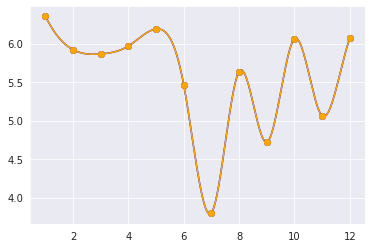

In [33]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_uniformis'

# for row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrrows():

row = df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
spline_current, current_min, current_max = d_splines[current][taxonomy]

index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
current_smooth_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_smooth_current)

ts_reference_smooth_warp = interpolate.splev(index_smooth_current, spline_reference)
ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)

ts_reference_smooth_warp = np.clip(ts_reference_smooth_warp, reference_min, reference_max)
ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)

current_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

# index_warp_arange = np.arange(np.ceil(current_warp.min()), np.floor(current_warp.max()), dtype=int)

# current_warp = inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

ts_reference = interpolate.splev(index_splines, spline_reference)
ts_current_warp = interpolate.splev(current_warp, spline_current)

ts_reference = np.clip(ts_reference, reference_min, reference_max)
ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

fig, ax = plt.subplots()

plt.plot(index_smooth_current, ts_reference_smooth_warp, color="blue")
plt.plot(index_smooth_current, ts_current_smooth_warp, color="orange")

plt.plot(index_splines, ts_reference, 'o', color="blue")
plt.plot(index_splines, ts_current_warp, 'o', color="orange")

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

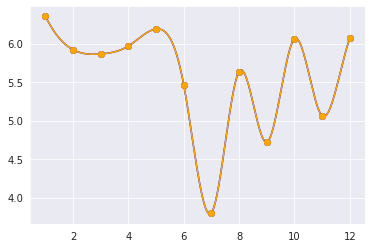

In [34]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_uniformis'

# for row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrrows():

row = df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

spline_reference, reference_min, reference_max = d_splines[current][taxonomy]
spline_current, current_min, current_max = d_splines[current][taxonomy]

index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
current_smooth_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_smooth_current)

ts_reference_smooth_warp = interpolate.splev(index_smooth_current, spline_reference)
ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)

ts_reference_smooth_warp = np.clip(ts_reference_smooth_warp, reference_min, reference_max)
ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)

current_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

index_warp_arange = np.arange(np.ceil(current_warp.min()), np.floor(current_warp.max()), dtype=int)

# current_warp = inv_linear_warp(row['a'].values[0], row['b'].values[0], index_warp_arange)

ts_reference = interpolate.splev(index_splines, spline_reference)
ts_current_warp = interpolate.splev(current_warp, spline_current)

ts_reference = np.clip(ts_reference, reference_min, reference_max)
ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

fig, ax = plt.subplots()

plt.plot(index_smooth_current, ts_reference_smooth_warp, color="blue")
plt.plot(index_smooth_current, ts_current_smooth_warp, color="orange")

plt.plot(index_splines, ts_reference, 'o', color="blue")
plt.plot(index_splines, ts_current_warp, 'o', color="orange")

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

In [35]:
inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

array([ 1.00011144,  2.0002107 ,  3.00030995,  4.0004092 ,  5.00050846,
        6.00060771,  7.00070697,  8.00080622,  9.00090548, 10.00100473,
       11.00110399, 12.00120324])

In [36]:
index_realtime = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

In [37]:
inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

array([ 1.00011144,  2.0002107 ,  3.00030995,  4.0004092 ,  5.00050846,
        6.00060771,  7.00070697,  8.00080622,  9.00090548, 10.00100473,
       11.00110399, 12.00120324])

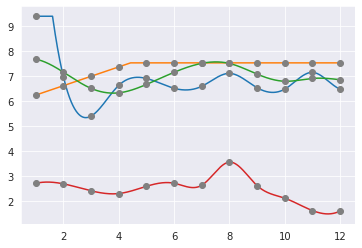

In [38]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_uniformis'

username_with_tax = set(df_username_presence.loc[df_username_presence.loc[:, taxonomy] > PRESENCE_THRESHOLD].index)

fig, ax = plt.subplots()

ix = 0
for name, row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrows():
    current = row['current']
    if current in username_with_tax and reference != current:
        spline_current, current_min, current_max = d_splines[current][taxonomy]
        
        index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
        current_smooth_warp = linear_warp(row['a'], row['b'], index_smooth_current)

        ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)
        ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)
        
        
        current_warp = linear_warp(row['a'], row['b'], index_splines)

        ts_current_warp = interpolate.splev(current_warp, spline_current)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)
        
        plt.plot(index_smooth_current, ts_current_smooth_warp)
        plt.plot(index_splines, ts_current_warp, 'o', color='grey')
        ix += 1
    if ix > 3:
        break

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

In [39]:
df_alignment_results.to_csv("../results/alignment_results.txt", sep="\t", index=False)

In [40]:
# 			T = [warpFunction(a, b, timepointReferenceSample.offsetID) for timepointReferenceSample in timepointsListReferenceSample]
# ##			T_inverse = [warpFunctionInverse(a, b, timepointCurrentSample.offsetID) for timepointCurrentSample in timepointsListCurrentSample]
# 			timepointCurrentSampleMin = warpFunctionInverse(a, b, min(CurrentSampleT))
# 			timepointCurrentSampleMax = warpFunctionInverse(a, b, max(CurrentSampleT))
# 			alpha = max(timepointReferenceSampleMin, timepointCurrentSampleMin)
# 			beta = min(timepointReferenceSampleMax, timepointCurrentSampleMax)
# 			overlap =  (beta - alpha) / (timepointReferenceSampleMax - timepointReferenceSampleMin)
# 			if overlap > OVERLAP_THRESHOLD and alpha < beta:
# 				[alignmentError, a, b] = getAlignmnetError(a, b, alpha, beta, timepointsListReferenceSample, timepointsListCurrentSample, taxonWeights, useSplines)
# 				if len(optimalAlignmentParameters) == 0 or optimalAlignmentParameters[0] > alignmentError:
# 					optimalAlignmentParameters = [alignmentError, a, b, alpha, beta, overlap]